In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from haversine import haversine

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import scipy as sp
import statsmodels.api as sm # statsmodel 기본 import
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk
from patsy import dmatrix

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


##### StatsModels를 이용한 레버리지 계산

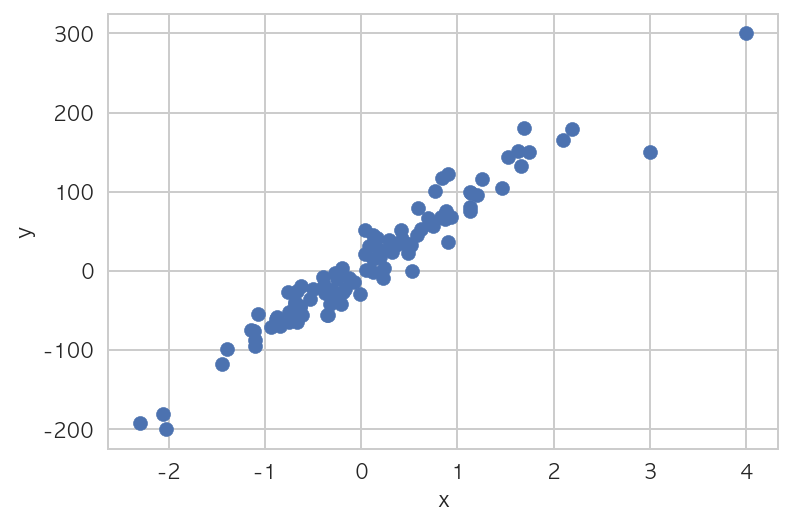

In [4]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                             coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)    #bias augmentation
y = np.hstack([y, data_100[1], data_101[1]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
# 선형회귀 진행
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           1.61e-61
Time:                        01:52:25   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

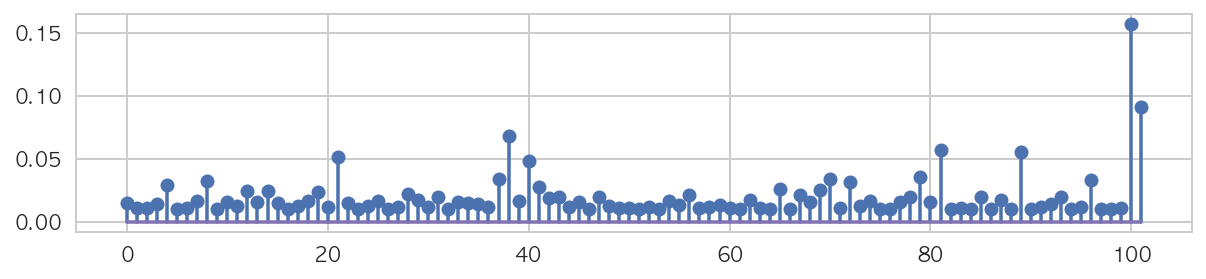

In [6]:
# 레버리지 구하기
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [9]:
print(hat)

[ 0.01516695  0.01119963  0.01107744  0.01374277  0.02878656  0.01041415
  0.01125576  0.01606417  0.03257963  0.01014885  0.01553914  0.01250262
  0.02459694  0.01565692  0.02457942  0.01460505  0.01021012  0.0120643
  0.01605503  0.0239386   0.01165165  0.05129059  0.0151323   0.00985232
  0.01237359  0.01626123  0.00986235  0.01183083  0.02220309  0.0174345
  0.01203702  0.01991263  0.0098375   0.01528896  0.01475726  0.01372415
  0.01198596  0.03378783  0.06764843  0.01612402  0.04792128  0.02724502
  0.0190858   0.01971908  0.01179221  0.01542131  0.00981397  0.0196743
  0.01228633  0.01117811  0.0109163   0.00980453  0.01186491  0.01016148
  0.01638805  0.01298791  0.02104222  0.01086322  0.01139019  0.01349858
  0.01058338  0.00980472  0.01755271  0.01065946  0.01009433  0.02562309
  0.00983591  0.02089362  0.01528715  0.0250016   0.03402463  0.01100677
  0.03174496  0.01214893  0.01631615  0.00982909  0.00999788  0.01556518
  0.01971644  0.03542004  0.01566805  0.05672477  0.00

In [11]:
hat.mean()

0.019607843137254905

In [12]:
hat.sum()

2.0000000000000004

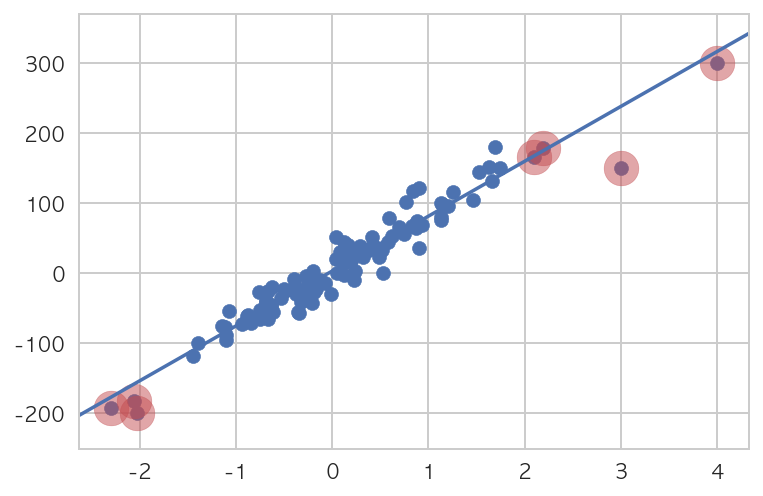

In [15]:
# 레버리지값이 레버리지 평균의 2배 이상인 데이터만 표시

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 2 * hat.mean()
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.show()

##### 레버리지의 영향

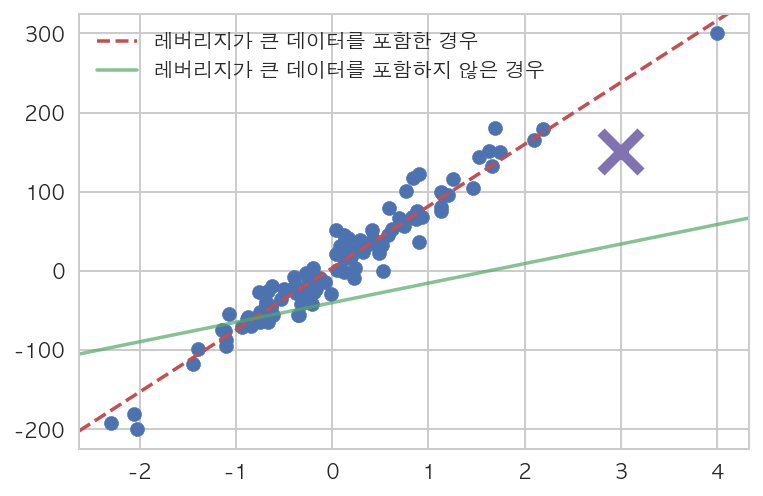

In [20]:
model2 = sm.OLS(y[:1], X[:1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                       c="g", alpha=0.7, ax=ax)
plt.plot(X0[-1], y[-1], marker = 'x', c='m', ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"])
plt.show()

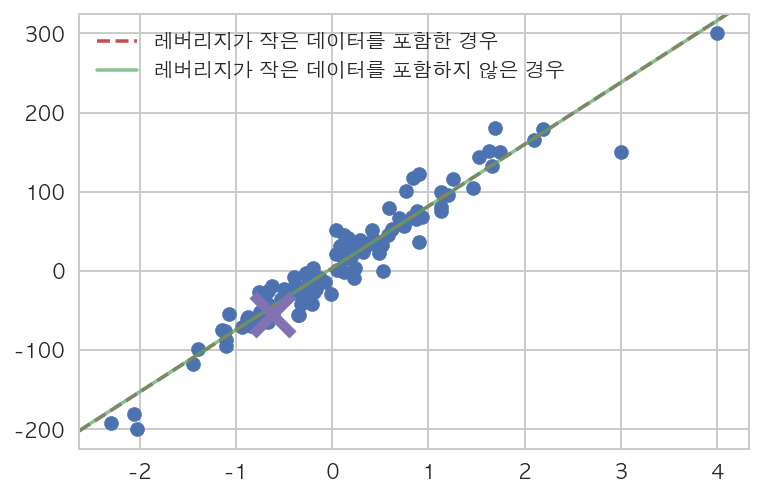

In [21]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"], 
           loc="upper left")
plt.show()

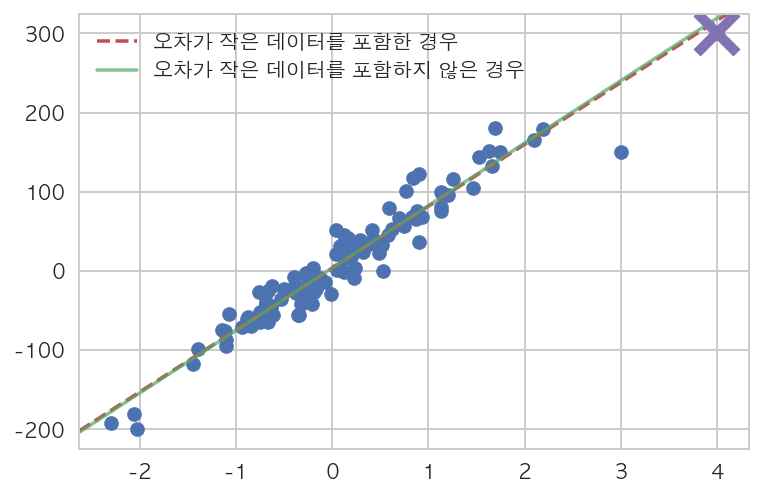

In [22]:
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"], 
           loc="upper left")
plt.show()

##### StatsModels를 이용한 표준화 잔차 계산

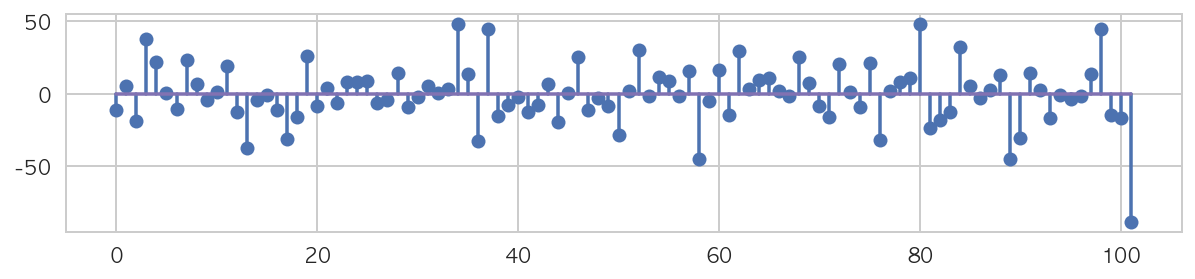

In [23]:
#잔차
plt.figure(figsize=(10,2))
plt.stem(result.resid)
plt.show()

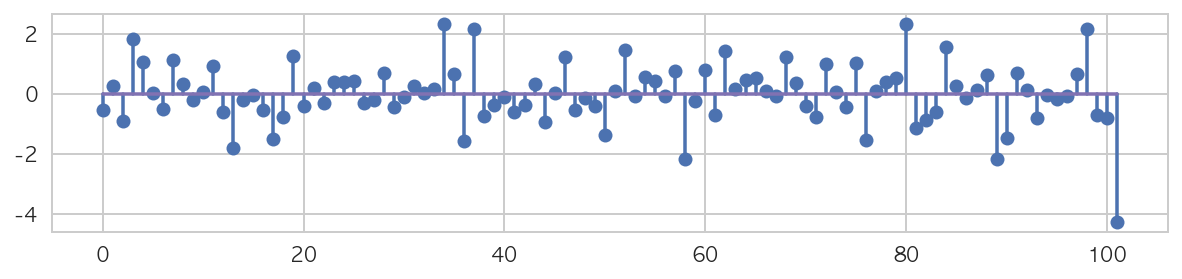

In [24]:
#표준화잔차 : y축이 달라짐
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.show()

##### Cook's distance : 레버리지와 표준화 잔차가 모두 큰 아웃라이어 판별

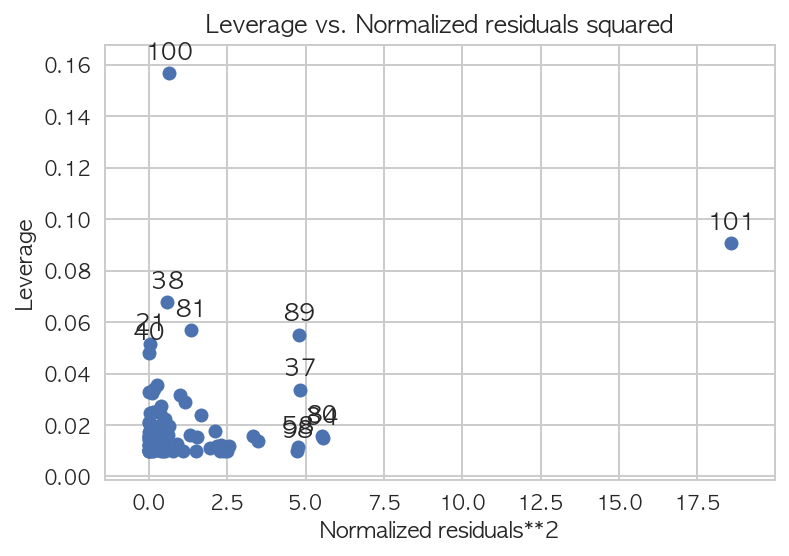

In [25]:
# plot_leverage_resid2 : 표준화잔차 제곱, 레버리지를 모두 표시
sm.graphics.plot_leverage_resid2(result)
plt.show()

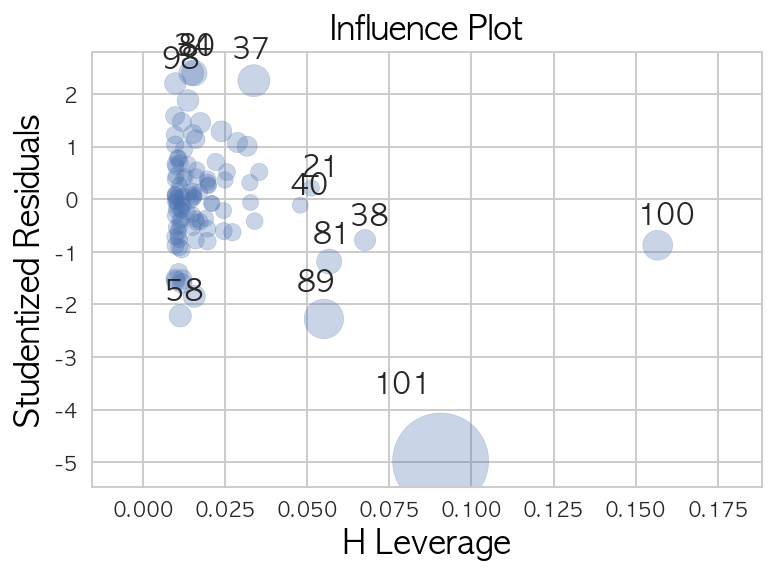

In [26]:
# influence_plot : Cook's distance를 버블 크기로 표시
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()